## ReadMe
Tutorial: 

https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b


data:  

https://www.kaggle.com/arjunbhasin2013/ccdata

In [1]:
# https://www.kaggle.com/arjunbhasin2013/ccdata


#api for k-means algo
from pyspark.ml.clustering import KMeans,KMeansModel

#ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html
#The metric computes the Silhouette measure using the squared Euclidean distance.

from numpy import array
from math import sqrt

#Build the api for the entrance
from pyspark.context import SparkContext,SparkConf
from pyspark.rdd import RDD
from pyspark.sql import SparkSession
import os
import sys


#Config
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jre1.8.0_301'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


sc = SparkContext(conf=SparkConf().setAppName("Kmeans").setMaster("local"))
print(f'sc:{sc}')
spark = SparkSession(sc)

sc:<SparkContext master=local appName=Kmeans>


In [12]:
import os

root = os.path.abspath(os.getcwd())
root

'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\CH3_K_means'

In [16]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()

path = root+'\\dataset\\CC_GENERAL.csv'
#data_customer = sc.textFile(path)
data_customer=spark.read.csv(path, header=True, inferSchema=True)
data_customer.printSchema()#import csv時
#data_customer.collect() #import RDD/ df時

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [17]:
data_customer=data_customer.na.drop()


## extract the required columns

we first extract the required columns using .columns, pass it as an input to Vector Assembler, a vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features/ columns.

## Assemble

In [23]:
from pyspark.ml.feature import VectorAssembler

type(data_customer) #pyspark.sql.dataframe.DataFrame，無法用names找出欄位名稱
data_customer.columns

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [45]:
type(data_customer)

pyspark.sql.dataframe.DataFrame

In [44]:
#remove the column: 'CUST_ID'
required_col = data_customer.columns[1:]
print(required_col)
#vector assemble
assemble=VectorAssembler(inputCols=required_col, outputCol='features')
print(type(assemble))

['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
<class 'pyspark.ml.feature.VectorAssembler'>


In [43]:
##????
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

In [39]:
assembled_data.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

# standardize

1. Now that all columns had transformed into a single feature vector
2. we need to standardize the data to bring them to a comparable scale. 

用 StandardScaler

E.g. Balance can have a scale from 10–1000 whereas balance frequency has a scale from 0–1 say. Euclidean distance is always impacted more by variables on a higher scale, hence it’s important to scale the variables out.

In [31]:
from pyspark.ml.feature import StandardScaler

In [32]:
scale=StandardScaler(inputCol='features',outputCol='standardized')

In [33]:
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

## K Means algorithm.

The KMeans function from pyspark.ml.clustering includes the following parameters:

1. k: 

分群數量，通常是指定值或是經驗值，但是若是無法得知，需要進行EDA，
##### Still wondering how to decide K? Let’s dig deep
https://towardsdatascience.com/unsupervised-learning-techniques-using-python-k-means-and-silhouette-score-for-clustering-d6dd1f30b660

2. maxIterations: 

執行迭代次數n次，但是若當entoid抖動誤差小於epsilon value，則無論是否達到n，模型都會進行early stopping


3. initializationMode: 

指定起始的centroids，
specifies either random initialization of centroids or initialization via k-means|| (similar to K-means ++)


4. epsilon: 

決定收斂的threshold，我希望是使用指定iteration 次數，以效率為主

5. initialModel 

提供預設的起始centroids，當啟用該變數時，演算法會執行一輪進行分配到最近的點。
If this parameter is used, the algorithm just runs once to allocate points to its nearest centroid

預設值:


train(k=4, maxIterations=20, minDivisibleClusterSize=1.0, seed=-1888008604) are the default values.

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.44752332646426074
Silhouette Score: 0.2877583415733337
Silhouette Score: 0.2467832405385038
Silhouette Score: 0.25915218179642147
Silhouette Score: 0.2650616711183566
Silhouette Score: 0.2906175048407014
Silhouette Score: 0.2974286832863345
Silhouette Score: 0.2947398261895235


Text(0, 0.5, 'cost')

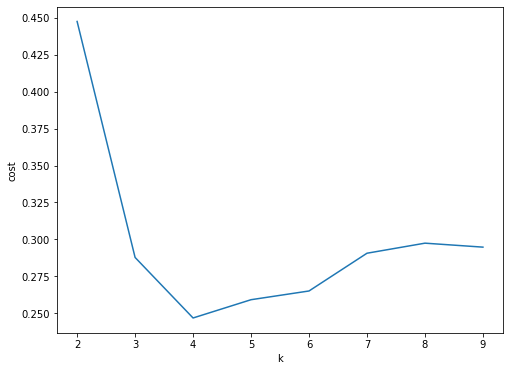

In [36]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

依照圖，肉眼是看到K=7 時，取得區域Silhouette Score最大值
然而並沒有所謂一定正確的K值。我們能回歸描述性統計解釋，並利用圖解釋客戶的機率分配。
而這部分就適合使用sklearn (documentation and PCA 降維)
或是把y軸放上SSE，我們能取得elbow plot。